In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
import networkx as nx

information
data.x: Node feature matrix with shape [num_nodes, num_node_features]

data.edge_index: Graph connectivity in COO format with shape [2, num_edges] and type torch.long

data.edge_attr: Edge feature matrix with shape [num_edges, num_edge_features]

data.y: Target to train against (may have arbitrary shape), e.g., node-level targets of shape [num_nodes, *] or graph-level targets of shape [1, *]

data.pos: Node position matrix with shape [num_nodes, num_dimensions]

In [2]:
edge_index = torch.tensor([[0, 1, 1, 2],
                           [1, 0, 2, 1]], dtype=torch.long)
x = torch.tensor([[-1], [0], [1]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index)

print(data)

Data(x=[3, 1], edge_index=[2, 4])


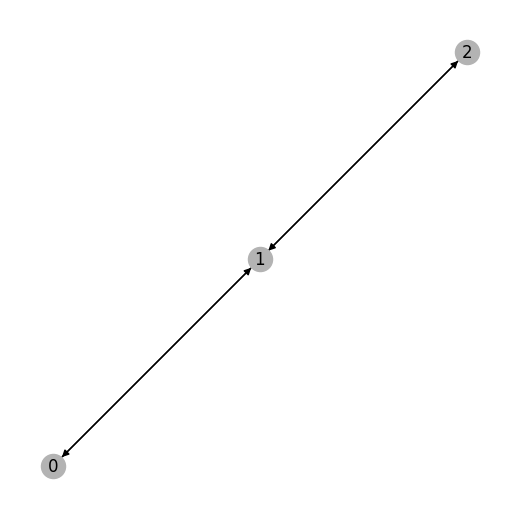

In [3]:
# print image of the graph
plt.figure(figsize=(5, 5))
nxg = to_networkx(data)
pos = nx.spring_layout(nxg)
nx.draw(nxg, pos, with_labels=True, node_color=[[.7, .7, .7]])
plt.show()

In [4]:
# print attributes of the nodes
print(data.x)

tensor([[-1.],
        [ 0.],
        [ 1.]])


In [7]:
# set new attributes for the nodes
data.x = torch.tensor([[-1, 4], [0, 5], [1, 6]], dtype=torch.float)
print(data['x'])

tensor([[-1.,  4.],
        [ 0.,  5.],
        [ 1.,  6.]])


In [6]:
print(data.keys())

['x', 'edge_index']


testing with my dataset

In [21]:
import pandas as pd
import numpy as np

In [10]:
# load
df = pd.read_csv('customdata/finaldata.csv')
print(df)

    id       dur  spkts  dpkts  sbytes  dbytes           rate  sttl  dttl  \
0    0  0.121478      6      4     258     172      74.087490   252   254   
1    1  0.649902     14     38     734   42014      78.473372    62   252   
2    2  1.623129      8     16     364   13186      14.170161    62   252   
3    3  1.681642     12     12     628     770      13.677108    62   252   
4    4  0.449454     10      6     534     268      33.373826   254   252   
5    5  0.380537     10      6     534     268      39.417980   254   252   
6    6  0.637109     10      8     534     354      26.683033   254   252   
7    7  0.521584     10      8     534     354      32.593026   254   252   
8    8  0.000007      2      0     200       0  142857.140900   254     0   
9    9  0.258687     10      6     534     268      57.985135   254   252   
10  10  0.304853     12      6    4142     268      55.764583   254   252   
11  11  2.093085     62     28   56329    2212      42.520967    62   252   

In [37]:
# insert into graph with pyg
# check shape of 'source' col
print(df['source'].shape)

# save it into an array with 1, 48 shape
# ok even though it does not have a second dimension, its fine leave it
# you just set it to have a second dimension and then the edge_index had three dimensions which is wrong so leave this
# code commented as what went wrong
# sources = df['source'].values.reshape(1, -1)
# print(sources.shape)


# need to make into a list i think, cannot do (, -1)
# ok yea just tested, need to be list to keep it the edge_index as two dimensions
# no that really made me want to die for a second
sources = df['source'].values.tolist()
destinations = df['destination'].values.tolist() 

(48,)


In [38]:
# make graph
edge_index = torch.tensor([sources, destinations], dtype=torch.long)

Data(edge_index=[2, 48])


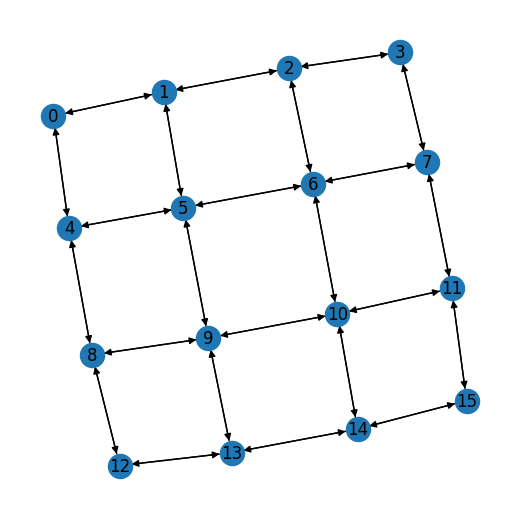

In [42]:
# display graph as image

data = Data(edge_index=edge_index)
print(data)

plt.figure(figsize=(5, 5))
nxg = to_networkx(data)
pos = nx.spring_layout(nxg)
nx.draw(nxg, pos, with_labels=True)
plt.show()

In [ ]:
# set features for all nodes, should be all columns except source, destination, and id
 
df = df.drop(['source', 'destination', 'id'], axis=1)

In [49]:
print(df.columns)
print(df.columns.shape)

Index(['dur', 'spkts', 'dpkts', 'sbytes', 'dbytes', 'rate', 'sttl', 'dttl',
       'sload', 'dload', 'sloss', 'dloss', 'sinpkt', 'dinpkt', 'sjit', 'djit',
       'swin', 'stcpb', 'dtcpb', 'dwin', 'tcprtt', 'synack', 'ackdat', 'smean',
       'dmean', 'trans_depth', 'response_body_len', 'ct_srv_src',
       'ct_state_ttl', 'ct_dst_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm',
       'ct_dst_src_ltm', 'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd',
       'ct_src_ltm', 'ct_srv_dst', 'is_sm_ips_ports', 'label'],
      dtype='object')
(40,)


In [48]:
# set features for all nodes
x = torch.tensor(df.values, dtype=torch.float)
data = (Data(x=x, edge_index=edge_index))
print(data['x'])
print(data.num_node_features)
print(data.num_classes)

tensor([[ 0.1215,  6.0000,  4.0000,  ...,  1.0000,  0.0000,  0.0000],
        [ 0.6499, 14.0000, 38.0000,  ...,  6.0000,  0.0000,  0.0000],
        [ 1.6231,  8.0000, 16.0000,  ...,  6.0000,  0.0000,  0.0000],
        ...,
        [ 0.3380, 10.0000,  6.0000,  ...,  3.0000,  0.0000,  0.0000],
        [ 0.4497, 10.0000,  6.0000,  ...,  6.0000,  0.0000,  0.0000],
        [ 0.2746, 10.0000,  6.0000,  ...,  8.0000,  0.0000,  0.0000]])
40


ok i think thats all? for loading into the graph, can gnn now?

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(data.num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return torch.nn.functional.log_softmax(x, dim=1)

# Training parameters
input_dim = df.num_features
hidden_dim = 64
output_dim = 2  # Binary classification (0 or 1)
learning_rate = 0.01
epochs = 100

# Initialize model, optimizer and loss function
model = GCN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.CrossEntropyLoss()

# Step 5: Training loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(train_data)
    loss = loss_fn(out, train_data.y)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item()}')

# Step 6: Evaluation
model.eval()
_, pred = model(test_data).max(dim=1)
correct = float(pred.eq(test_data.y).sum().item())
accuracy = correct / test_data.num_nodes
print(f'Accuracy: {accuracy:.4f}')    